In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

path = "/gpfs/adupuy/cosmicweb_asim/ASIM_TSC/samples/training/0.hdf5"

# ---------------------------
# 1. 통계 → 단일 테이블 생성 함수
# ---------------------------
def collect_stats(x):
    """Return dict of statistics for array x."""
    x = x.astype(np.float64)
    stats = {
        "min": np.nanmin(x),
        "max": np.nanmax(x),
        "mean": np.nanmean(x),
        "std": np.nanstd(x),
    }
    return stats


def print_stats_table(stats_dict):
    """
    stats_dict = {
        "ngal_before": {...},
        "ngal_after": {...},
        "vpec_before": {...},
        ...
    }
    """
    # 모든 stat key 목록 확보
    stat_keys = list(next(iter(stats_dict.values())).keys())
    col_keys = list(stats_dict.keys())

    # column width 계산
    col_widths = {col: max(len(col), 12) for col in col_keys}
    stat_width = max(len("stat"), max(len(k) for k in stat_keys))

    # 헤더 출력
    header = "stat".ljust(stat_width) + " | "
    for col in col_keys:
        header += col.ljust(col_widths[col]) + " | "
    print("\n" + header)
    print("-" * len(header))

    # row 출력
    for stat in stat_keys:
        row = stat.ljust(stat_width) + " | "
        for col in col_keys:
            val = stats_dict[col][stat]
            row += f"{val: .3e}".ljust(col_widths[col]) + " | "
        print(row)

    print("-" * len(header))


# ---------------------------
# 2. 정규화 함수
# ---------------------------

def normalize_ngal(ngal):
    mean = np.mean(ngal)
    std = np.std(ngal)
    return (ngal - mean) / std

def normalize_vpec(vpec):
    vpec_clipped = np.clip(vpec, -3000, 3000)
    mean = np.mean(vpec_clipped)
    std = np.std(vpec_clipped)
    return (vpec_clipped - mean) / std

def normalize_rho(rho):
    mean = np.mean(rho)
    std = np.std(rho)
    return (rho - mean) / std


# ---------------------------
# 3. 데이터 로드
# ---------------------------

with h5py.File(path, "r") as f:
    input_data = f["input"][0]
    rho = f["output_rho"][0, 0]

ngal = input_data[0]
vpec = input_data[1]

# Sampling
def sample_flat(x, n=200_000):
    x_flat = x.reshape(-1)
    if len(x_flat) > n:
        idx = np.random.choice(len(x_flat), n, replace=False)
        x_flat = x_flat[idx]
    return x_flat

ngal_flat = sample_flat(ngal)
vpec_flat = sample_flat(vpec)
rho_flat  = sample_flat(rho)

# ---------------------------
# 4. 정규화
# ---------------------------

ngal_norm = normalize_ngal(ngal_flat)
vpec_norm = normalize_vpec(vpec_flat)
rho_norm  = normalize_rho(rho_flat)

# ---------------------------
# 5. 전체 단일 테이블 생성
# ---------------------------

stats_dict = {
    "ngal_before": collect_stats(ngal_flat),
    "ngal_after":  collect_stats(ngal_norm),
    "vpec_before": collect_stats(vpec_flat),
    "vpec_after":  collect_stats(vpec_norm),
    "rho_before":  collect_stats(rho_flat),
    "rho_after":   collect_stats(rho_norm),
}

print_stats_table(stats_dict)



stat | ngal_before  | ngal_after   | vpec_before  | vpec_after   | rho_before   | rho_after    | 
-------------------------------------------------------------------------------------------------
min  |  0.000e+00   | -5.595e-02   | -8.876e+02   | -3.246e+01   |  2.697e-02   | -4.453e-01   | 
max  |  1.000e+00   |  2.805e+02   |  1.756e+03   |  6.417e+01   |  1.369e+02   |  6.235e+01   | 
mean |  1.994e-04   | -3.126e-09   |  4.795e-01   | -5.660e-10   |  9.976e-01   | -2.428e-08   | 
std  |  3.564e-03   |  1.000e+00   |  2.736e+01   |  1.000e+00   |  2.180e+00   |  1.000e+00   | 
-------------------------------------------------------------------------------------------------


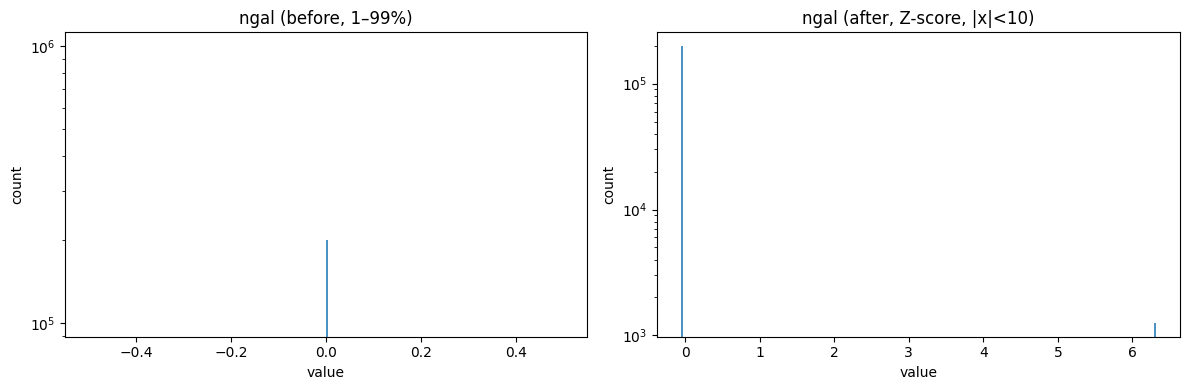

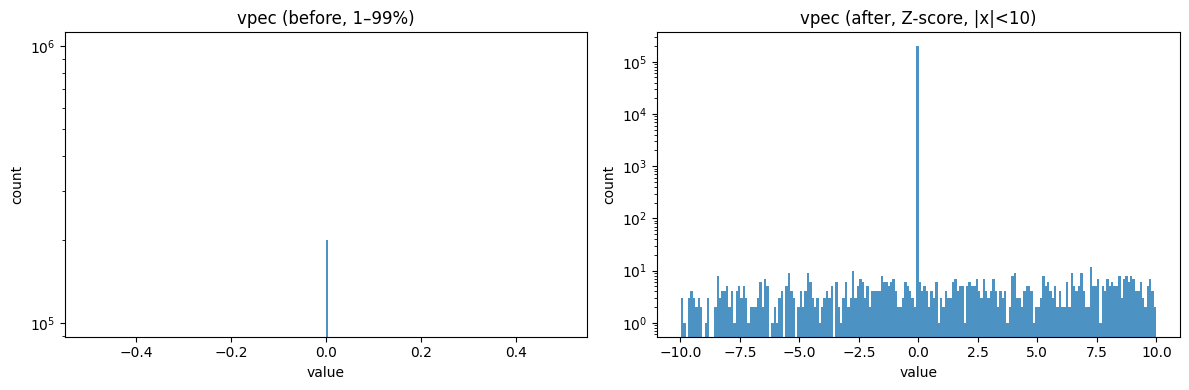

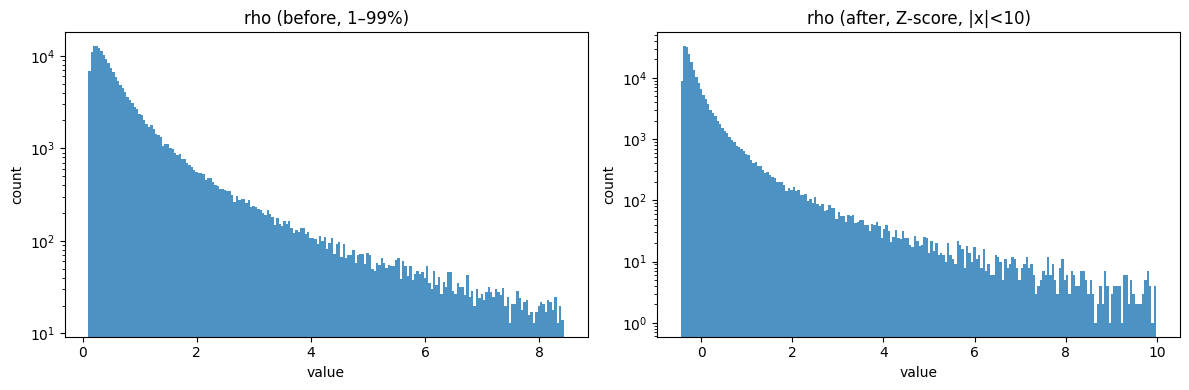

In [14]:
# ============================================================
# 6. 전/후 히스토그램 플롯 함수
# ============================================================

def plot_hist_before_after(x_before, x_after, title, bins=200):
    # Before: 1–99% 구간만 사용 (outlier 제외 시각화)
    p1, p99 = np.percentile(x_before, [1, 99])
    x_before_core = x_before[(x_before >= p1) & (x_before <= p99)]

    # After: Z-score → ±10 구간만 시각화
    x_after_core = x_after[(x_after >= -10) & (x_after <= 10)]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # -------- BEFORE --------
    axes[0].hist(x_before_core, bins=bins, alpha=0.8)
    axes[0].set_title(f"{title} (before, 1–99%)")
    axes[0].set_xlabel("value")
    axes[0].set_ylabel("count")
    axes[0].set_yscale("log")

    # -------- AFTER --------
    axes[1].hist(x_after_core, bins=bins, alpha=0.8)
    axes[1].set_title(f"{title} (after, Z-score, |x|<10)")
    axes[1].set_xlabel("value")
    axes[1].set_ylabel("count")
    axes[1].set_yscale("log")

    plt.tight_layout()
    plt.show()


# ============================================================
# 7. 3개 필드에 대해 플롯 실행
# ============================================================

plot_hist_before_after(ngal_flat, ngal_norm, "ngal")
plot_hist_before_after(vpec_flat, vpec_norm, "vpec")
plot_hist_before_after(rho_flat,  rho_norm,  "rho")


In [ ]:
# ================================================
# Load ngal only & compute stats
# ================================================
with h5py.File(path, "r") as f:
    input_data = f["input"][0]
ngal = input_data[0]

ngal_flat = ngal.reshape(-1)

# Statistics
ng_min  = np.min(ngal_flat)
ng_max  = np.max(ngal_flat)
ng_mean = np.mean(ngal_flat)
ng_std  = np.std(ngal_flat)

print("=== NGAL Statistics ===")
print(f"Min  : {ng_min:.6e}")
print(f"Max  : {ng_max:.6e}")
print(f"Mean : {ng_mean:.6e}")
print(f"Std  : {ng_std:.6e}")

# ================================================
# Log-scale histogram with stats annotation
# ================================================
plt.figure(figsize=(10,5))
plt.hist(ngal_flat, bins=100, alpha=0.75)
plt.yscale("log")

plt.title("NGAL Histogram (Log-Scale)", fontsize=15)
plt.xlabel("ngal value")
plt.ylabel("Count (log scale)")
plt.grid(True, alpha=0.3)

# annotation text
text = (
    f"min  = {ng_min:.2e}\n"
    f"max  = {ng_max:.2e}\n"
    f"mean = {ng_mean:.2e}\n"
    f"std  = {ng_std:.2e}"
)

plt.annotate(
    text, 
    xy=(0.98, 0.98), xycoords="axes fraction",
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()


=== NGAL Statistics ===
Min  : 0.000000e+00
Max  : 1.000000e+00
Mean : 1.882748e-04
Std  : 2.869337e-03


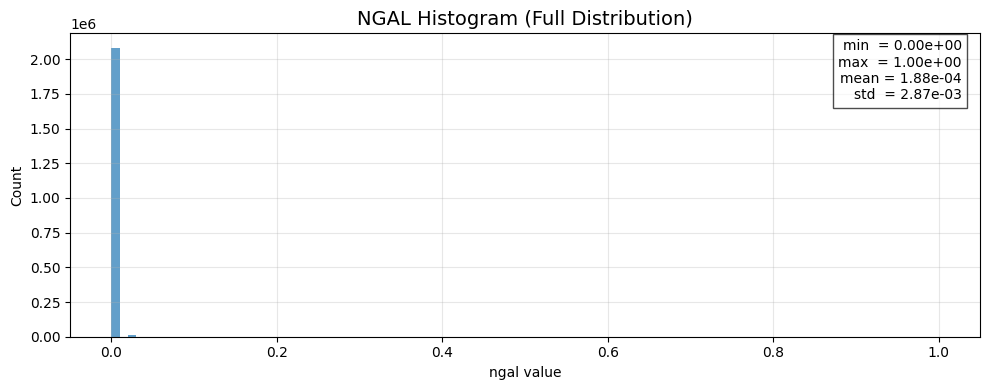

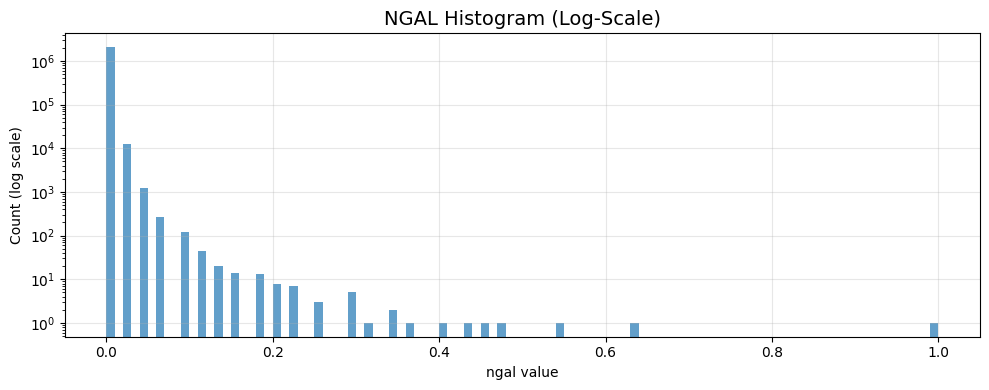

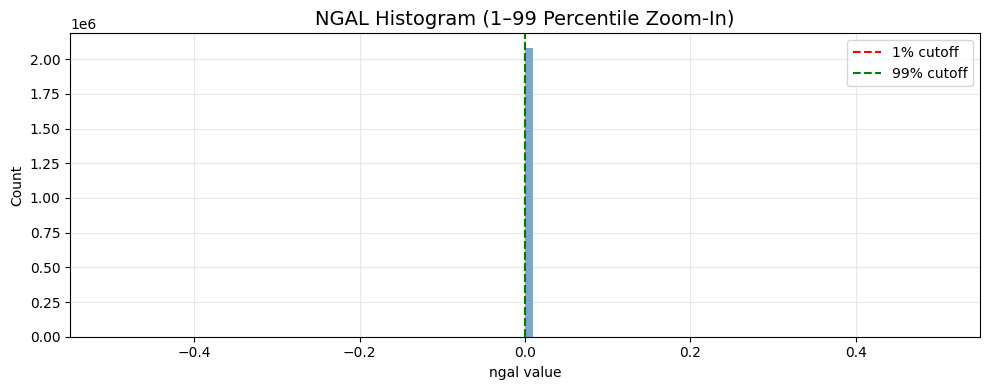

In [ ]:
# ================================================
# 0. Load ngal only & compute stats
# ================================================
with h5py.File(path, "r") as f:
    input_data = f["input"][0]
ngal = input_data[0]

# Flatten (sampling optional)
ngal_flat = ngal.reshape(-1)

# 통계 계산
ng_min  = np.min(ngal_flat)
ng_max  = np.max(ngal_flat)
ng_mean = np.mean(ngal_flat)
ng_std  = np.std(ngal_flat)

print("=== NGAL Statistics ===")
print(f"Min  : {ng_min:.6e}")
print(f"Max  : {ng_max:.6e}")
print(f"Mean : {ng_mean:.6e}")
print(f"Std  : {ng_std:.6e}")

# ================================================
# 1. Histogram (full)
# ================================================
plt.figure(figsize=(10,4))
plt.hist(ngal_flat, bins=100, alpha=0.7)
plt.title("NGAL Histogram (Full Distribution)", fontsize=14)
plt.xlabel("ngal value")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

# stats annotation
text = (
    f"min  = {ng_min:.2e}\n"
    f"max  = {ng_max:.2e}\n"
    f"mean = {ng_mean:.2e}\n"
    f"std  = {ng_std:.2e}"
)
plt.annotate(text, xy=(0.98, 0.98), xycoords="axes fraction",
             ha="right", va="top",
             fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

# ================================================
# 2. Histogram (log y-scale)
# ================================================
plt.figure(figsize=(10,4))
plt.hist(ngal_flat, bins=100, alpha=0.7)
plt.yscale("log")
plt.title("NGAL Histogram (Log-Scale)", fontsize=14)
plt.xlabel("ngal value")# ================================================
# Load ngal only & compute stats
# ================================================
with h5py.File(path, "r") as f:
    input_data = f["input"][0]
ngal = input_data[0]

ngal_flat = ngal.reshape(-1)

# Statistics
ng_min  = np.min(ngal_flat)
ng_max  = np.max(ngal_flat)
ng_mean = np.mean(ngal_flat)
ng_std  = np.std(ngal_flat)

print("=== NGAL Statistics ===")
print(f"Min  : {ng_min:.6e}")
print(f"Max  : {ng_max:.6e}")
print(f"Mean : {ng_mean:.6e}")
print(f"Std  : {ng_std:.6e}")

# ================================================
# Log-scale histogram with stats annotation
# ================================================
plt.figure(figsize=(10,5))
plt.hist(ngal_flat, bins=100, alpha=0.75)
plt.yscale("log")

plt.title("NGAL Histogram (Log-Scale)", fontsize=15)
plt.xlabel("ngal value")
plt.ylabel("Count (log scale)")
plt.grid(True, alpha=0.3)

# annotation text
text = (
    f"min  = {ng_min:.2e}\n"
    f"max  = {ng_max:.2e}\n"
    f"mean = {ng_mean:.2e}\n"
    f"std  = {ng_std:.2e}"
)

plt.annotate(
    text, 
    xy=(0.98, 0.98), xycoords="axes fraction",
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()

plt.ylabel("Count (log scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ================================================
# 3. Histogram (1–99 percentile zoom-in)
# ================================================
p1, p99 = np.percentile(ngal_flat, [1, 99])
mask = (ngal_flat >= p1) & (ngal_flat <= p99)
ngal_zoom = ngal_flat[mask]

plt.figure(figsize=(10,4))
plt.hist(ngal_zoom, bins=100, alpha=0.7, color="steelblue")# ================================================
# Load ngal only & compute stats
# ================================================
with h5py.File(path, "r") as f:
    input_data = f["input"][0]
ngal = input_data[0]

ngal_flat = ngal.reshape(-1)

# Statistics
ng_min  = np.min(ngal_flat)
ng_max  = np.max(ngal_flat)
ng_mean = np.mean(ngal_flat)
ng_std  = np.std(ngal_flat)

print("=== NGAL Statistics ===")
print(f"Min  : {ng_min:.6e}")
print(f"Max  : {ng_max:.6e}")
print(f"Mean : {ng_mean:.6e}")
print(f"Std  : {ng_std:.6e}")

# ================================================
# Log-scale histogram with stats annotation
# ================================================
plt.figure(figsize=(10,5))
plt.hist(ngal_flat, bins=100, alpha=0.75)
plt.yscale("log")

plt.title("NGAL Histogram (Log-Scale)", fontsize=15)
plt.xlabel("ngal value")
plt.ylabel("Count (log scale)")# ================================================
# Load ngal only & compute stats
# ================================================
with h5py.File(path, "r") as f:
    input_data = f["input"][0]
ngal = input_data[0]

ngal_flat = ngal.reshape(-1)

# Statistics
ng_min  = np.min(ngal_flat)
ng_max  = np.max(ngal_flat)
ng_mean = np.mean(ngal_flat)
ng_std  = np.std(ngal_flat)

print("=== NGAL Statistics ===")
print(f"Min  : {ng_min:.6e}")
print(f"Max  : {ng_max:.6e}")
print(f"Mean : {ng_mean:.6e}")
print(f"Std  : {ng_std:.6e}")

# ================================================
# Log-scale histogram with stats annotation
# ================================================
plt.figure(figsize=(10,5))
plt.hist(ngal_flat, bins=100, alpha=0.75)
plt.yscale("log")

plt.title("NGAL Histogram (Log-Scale)", fontsize=15)
plt.xlabel("ngal value")
plt.ylabel("Count (log scale)")
plt.grid(True, alpha=0.3)

# annotation text
text = (
    f"min  = {ng_min:.2e}\n"# ================================================
# Load ngal only & compute stats
# ================================================
with h5py.File(path, "r") as f:
    input_data = f["input"][0]
ngal = input_data[0]

ngal_flat = ngal.reshape(-1)

# Statistics
ng_min  = np.min(ngal_flat)
ng_max  = np.max(ngal_flat)
ng_mean = np.mean(ngal_flat)
ng_std  = np.std(ngal_flat)

print("=== NGAL Statistics ===")
print(f"Min  : {ng_min:.6e}")
print(f"Max  : {ng_max:.6e}")
print(f"Mean : {ng_mean:.6e}")
print(f"Std  : {ng_std:.6e}")

# ================================================
# Log-scale histogram with stats annotation
# ================================================
plt.figure(figsize=(10,5))
plt.hist(ngal_flat, bins=100, alpha=0.75)
plt.yscale("log")

plt.title("NGAL Histogram (Log-Scale)", fontsize=15)
plt.xlabel("ngal value")
plt.ylabel("Count (log scale)")
plt.grid(True, alpha=0.3)

# annotation text
text = (
    f"min  = {ng_min:.2e}\n"
    f"max  = {ng_max:.2e}\n"
    f"mean = {ng_mean:.2e}\n"
    f"std  = {ng_std:.2e}"
)

plt.annotate(
    text, 
    xy=(0.98, 0.98), xycoords="axes fraction",
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()

    f"max  = {ng_max:.2e}\n"
    f"mean = {ng_mean:.2e}\n"
    f"std  = {ng_std:.2e}"
)

plt.annotate(
    text, 
    xy=(0.98, 0.98), xycoords="axes fraction",
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()

plt.grid(True, alpha=0.3)

# annotation text
text = (
    f"min  = {ng_min:.2e}\n"
    f"max  = {ng_max:.2e}\n"
    f"mean = {ng_mean:.2e}\n"
    f"std  = {ng_std:.2e}"
)

plt.annotate(
    text, 
    xy=(0.98, 0.98), xycoords="axes fraction",
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()

plt.title("NGAL Histogram (1–99 Percentile Zoom-In)", fontsize=14)
plt.xlabel("ngal value")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

plt.axvline(p1, color="red", ls="--", label="1% cutoff")
plt.axvline(p99, color="green", ls="--", label="99% cutoff")
plt.legend()

plt.tight_layout()
plt.show()
